In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

rsna_pneumonia_detection_challenge_path = kagglehub.competition_download('rsna-pneumonia-detection-challenge')

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import pydicom
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Veri Yükleme Fonksiyonu
def load_data(data_dir, labels_csv, img_size=32, max_images=5000):
    labels_df = pd.read_csv(labels_csv)
    labels_df = labels_df.drop_duplicates(subset='patientId')
    images = []
    labels = []

    for index, row in labels_df.iterrows():
        dicom_path = os.path.join(data_dir, row['patientId'] + '.dcm')
        if not os.path.exists(dicom_path):
            continue
        dicom = pydicom.dcmread(dicom_path)
        img = dicom.pixel_array
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        images.append(img)
        labels.append(1 if row['Target'] == 1 else 0)
        if len(images) >= max_images:
            break

    images = np.array(images).reshape(-1, img_size, img_size, 1)
    labels = np.array(labels)
    return images, labels

In [ ]:
# Kaggle İçin Dosya Yolları
data_dir = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
labels_csv = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
X, y = load_data(data_dir, labels_csv, img_size=32, max_images=5000)

In [ ]:
# Veri setinde sınıf dağılımı
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Sınıf {cls}: {count} örnek")

Sınıf 0: 3469 örnek
Sınıf 1: 1531 örnek


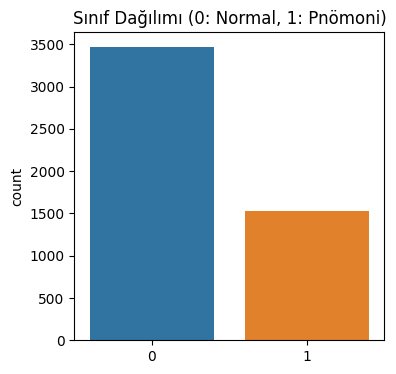

In [ ]:
plt.figure(figsize=(4, 4))
sns.countplot(x=y)
plt.title("Sınıf Dağılımı (0: Normal, 1: Pnömoni)")
plt.show()

In [ ]:
# Veri Setlerini Böl
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

In [ ]:
# class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7207578253706755, 1: 1.632462686567164}


In [ ]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
def build_classic_lenet5():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 1)),
        layers.Conv2D(6, kernel_size=(5, 5), activation='tanh'),
        AveragePooling2D(pool_size=(2, 2)),

        layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),
        AveragePooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_classic_lenet5()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Model Eğitimi
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6472 - loss: 0.6345 - val_accuracy: 0.6520 - val_loss: 0.6419
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7168 - loss: 0.5713 - val_accuracy: 0.7800 - val_loss: 0.4887
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7192 - loss: 0.5627 - val_accuracy: 0.7960 - val_loss: 0.4790
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7421 - loss: 0.5451 - val_accuracy: 0.6920 - val_loss: 0.6085
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7135 - loss: 0.5536 - val_accuracy: 0.7300 - val_loss: 0.5479
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7092 - loss: 0.5455 - val_accuracy: 0.7580 - val_loss: 0.5124


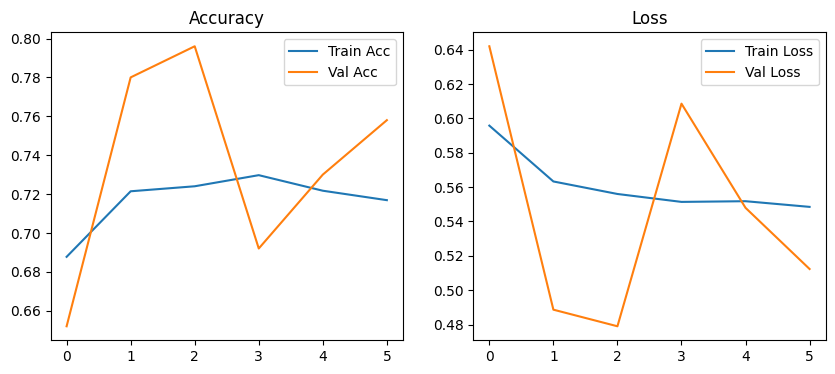

In [ ]:
# Eğitim Sonuçları
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [ ]:
# Test Setinde Tahmin ve Metrikler
y_pred = (model.predict(X_test) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
f1 = f1_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Sensitivity", "Specificity", "F1 Score"],
    "Value": [accuracy, precision, sensitivity, specificity, f1]
})
print(metrics_df)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
        Metric     Value
0     Accuracy  0.758000
1    Precision  0.605960
2  Sensitivity  0.598039
3  Specificity  0.828530
4     F1 Score  0.601974


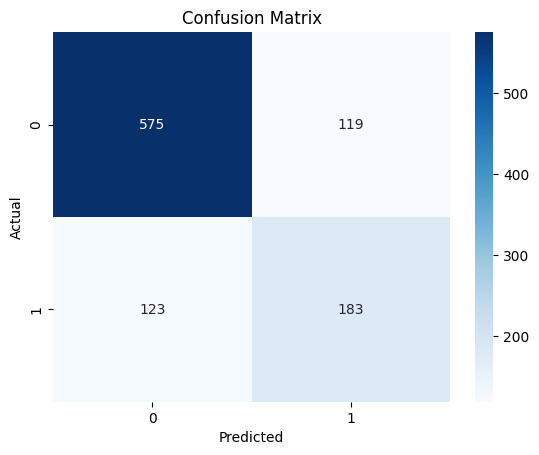

In [ ]:
#Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🔧 Training with learning rate = 0.1

🔧 Training with learning rate = 0.001

🔧 Training with learning rate = 0.0001

🔧 Training with learning rate = 1e-05


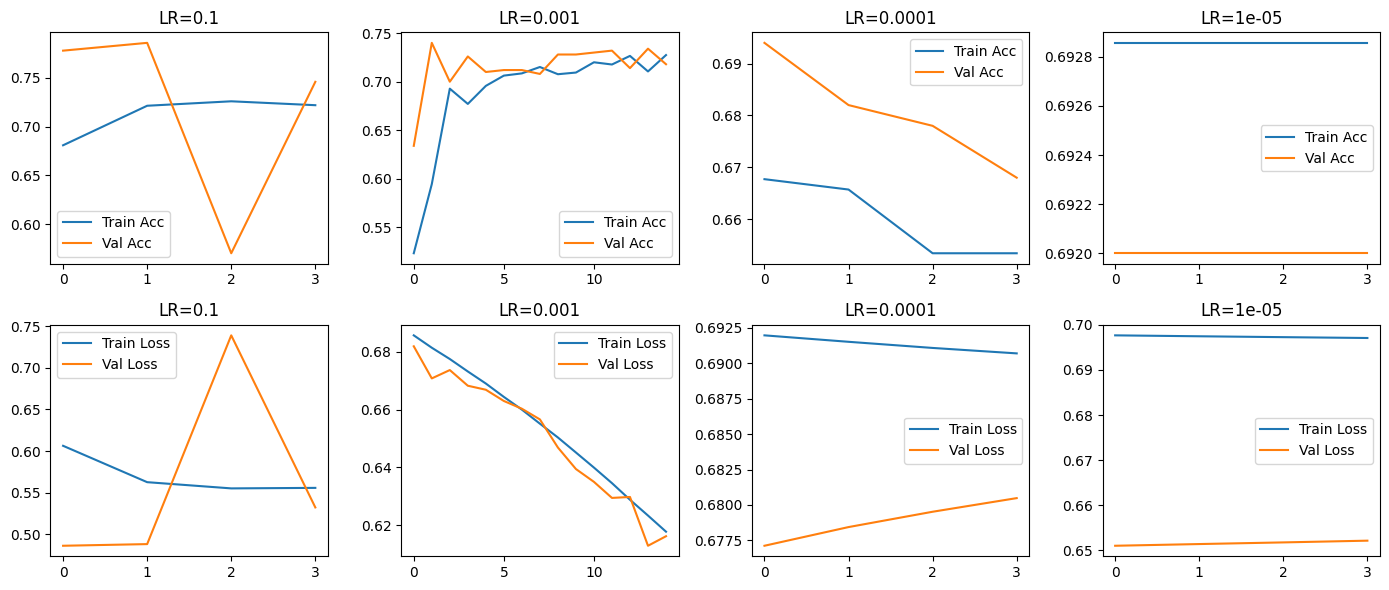

In [ ]:
# SGD ile Farklı Learning Rate Denemeleri
from tensorflow.keras.optimizers import SGD

learning_rates = [0.1, 0.001, 0.0001, 0.00001]
histories = {}

for lr in learning_rates:
    print(f"\n🔧 Training with learning rate = {lr}")

    model = build_classic_lenet5()
    optimizer = SGD(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=0  # Eğitim loglarını kapatmak için
    )

    histories[lr] = history


plt.figure(figsize=(14, 6))

for i, lr in enumerate(learning_rates):
    history = histories[lr]
    plt.subplot(2, 4, i+1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"LR={lr}")
    plt.legend()

    plt.subplot(2, 4, i+5)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"LR={lr}")
    plt.legend()

plt.tight_layout()
plt.show()
